## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [126]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
import torch.nn as nn

from collections import Counter

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [127]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [129]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
def getwords(text):
    lines = text.split('\n')
    lines = [line.strip(r'\"') for line in lines]
    words = ' '.join(lines).split()

    punct = set(string.punctuation)
    words = [''.join([char for char in list(word) if char not in punct]) for word in words]

    return words

text = "".join(text).lower()
words = getwords(text)
wordfreq = Counter(words)
tokens = sorted(wordfreq, key=wordfreq.get)
num_tokens = len(tokens)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
#tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [132]:
# dict <index>:<char>
# Your great code here
idx2token = {i:j for i,j in enumerate(tokens)}
token2idx = {i:j for j,i in idx2token.items()}
# dict <char>:<index>
# Your great code here
batch_size = 16
seq_size = 32
gradients_norm = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [134]:
# Your code here
class rnn_net(nn.Module):
    def __init__(self, n_vocab, embedding_size=64, rnn_size=64):
        super(rnn_net, self).__init__()
        self.rnn_size = rnn_size

        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.RNN(embedding_size, rnn_size, batch_first=True)
        self.dense = nn.Linear(rnn_size, n_vocab)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state
    
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.rnn_size))

def get_batches(words, token2idx, batch_size, seq_size):
    word_ints = [token2idx[word] for word in words]
    num_batches = int(len(word_ints) / (batch_size * seq_size))
    Xs = word_ints[:num_batches*batch_size*seq_size]
    Ys = np.zeros_like(Xs)
    Ys[:-1] = Xs[1:]
    Ys[-1] = Xs[0]
    Xs = np.reshape(Xs, (num_batches*batch_size, seq_size))
    Ys= np.reshape(Ys, (num_batches*batch_size, seq_size))
    
    for i in range(0, num_batches*batch_size, batch_size):
        yield Xs[i:i+batch_size, :], Ys[i:i+batch_size, :]

def plt1(loss):
    plt.figure(figsize = (10 , 10))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.plot(np.arange(len(loss)) + 1, loss, label="Training loss")

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [135]:
# Your plot code here
def train_rnn(net, words, vocab_to_int, int_to_vocab, n_vocab, n_epoch):
    net = net.to(device)
    net.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    loss_train = []
    
    for epoch in tqdm(range(n_epoch)):
        batches = get_batches(words, vocab_to_int, batch_size, seq_size)
        state_h = net.zero_state(batch_size)

        state_h = state_h.to(device)
        for x, y in batches:
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            optimizer.zero_grad()

            logits, state_h = net(x, state_h)
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()

            loss_value = loss.item()
            loss_train.append(loss_value)

            loss.backward()            
            optimizer.step()

        print(f"Epoch: {epoch}; Loss: {loss_value}")

    return loss_train


def train_lstm(net, words, vocab_to_int, int_to_vocab, n_vocab, n_epoch):
    net = net.to(device)
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_train = []
    for epoch in tqdm(range(n_epoch)):
        batches = get_batches(words, vocab_to_int, batch_size, seq_size)
        state_h, state_c = net.zero_state(batch_size)
        state_h = state_h.to(device)
        state_c = state_h.to(device)
        for x, y in batches:
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)
            optimizer.zero_grad()
            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)
            state_h = state_h.detach()
            state_c = state_h.detach()
            loss_value = loss.item()
            loss_train.append(loss_value)
            loss.backward()
            optimizer.step()
        print("Epoch: ",end='')
        print(epoch, end='    ')
        print("Loss: ", end='')
        print(loss_value)

    return loss_train

In [136]:
rnn_model = rnn_net(num_tokens)
loss = train_rnn(rnn_model, words, token2idx, idx2token, num_tokens, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0; Loss: 6.469067096710205
Epoch: 1; Loss: 6.002410888671875
Epoch: 2; Loss: 5.539708614349365
Epoch: 3; Loss: 5.047208786010742
Epoch: 4; Loss: 4.67360258102417
Epoch: 5; Loss: 4.341364860534668
Epoch: 6; Loss: 4.044158458709717
Epoch: 7; Loss: 3.7356748580932617
Epoch: 8; Loss: 3.5573067665100098
Epoch: 9; Loss: 3.35201358795166
Epoch: 10; Loss: 3.162217378616333
Epoch: 11; Loss: 3.002612352371216
Epoch: 12; Loss: 2.8587119579315186
Epoch: 13; Loss: 2.751497983932495
Epoch: 14; Loss: 2.584247350692749
Epoch: 15; Loss: 2.482203483581543
Epoch: 16; Loss: 2.352057933807373
Epoch: 17; Loss: 2.2577152252197266
Epoch: 18; Loss: 2.148023843765259
Epoch: 19; Loss: 2.1171627044677734
Epoch: 20; Loss: 2.0546023845672607
Epoch: 21; Loss: 1.9692118167877197
Epoch: 22; Loss: 2.004014253616333
Epoch: 23; Loss: 1.8494077920913696
Epoch: 24; Loss: 1.806672215461731
Epoch: 25; Loss: 1.7059910297393799
Epoch: 26; Loss: 1.7113498449325562
Epoch: 27; Loss: 1.6484054327011108
Epoch: 28; Loss: 1.66

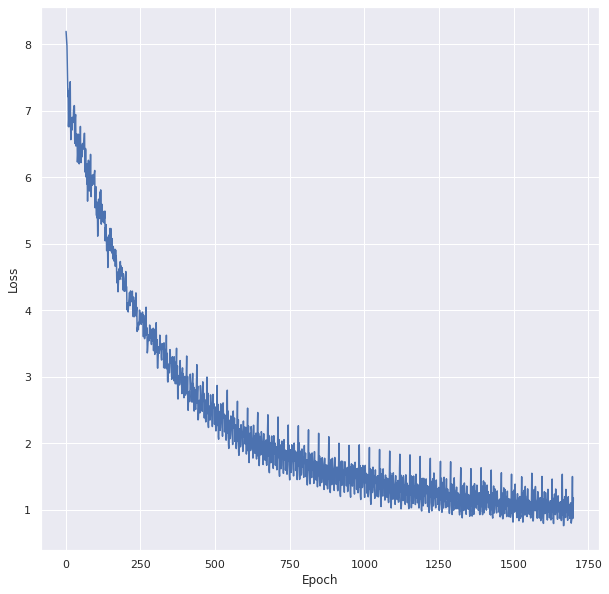

In [141]:
plt1(loss)

In [137]:
import torch.nn.functional as F

MAX_LENGTH  = 128
def generate_sample_rnn(char_rnn, seed_phrase=['hello'], max_length=MAX_LENGTH, temperature=1.0, token2idx=token2idx, idx2token=idx2token):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.eval()
    x_sequence = [token2idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.zero_state(1)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence, hid_state)
    #start generating
    for i in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence, hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][-1]

        next_ix = np.random.choice(len(idx2token), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ' '.join([idx2token[ix] for ix in x_sequence.data.numpy()[0]])

In [138]:
generated_text = generate_sample_rnn(rnn_model, seed_phrase=['that', 'thereby'], max_length=12, temperature=0.2)
print(generated_text)

that thereby speak or state itself confounded to decay ruin o do


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [145]:
# Your beautiful code here
class lstm_net(nn.Module):
    def __init__(self, n_vocab, embedding_size=64, lstm_size=64):
        super(lstm_net, self).__init__()
        self.lstm_size = lstm_size

        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size, lstm_size, batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state
    
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),torch.zeros(1, batch_size, self.lstm_size))

def train_lstm(net, words, vocab_to_int, int_to_vocab, n_vocab, n_epoch):
    net = net.to(device)
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_train = []
    for epoch in tqdm(range(n_epoch)):
        batches = get_batches(words, vocab_to_int, batch_size, seq_size)
        state_h, state_c = net.zero_state(batch_size)
        state_h = state_h.to(device)
        state_c = state_h.to(device)
        for x, y in batches:
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)
            optimizer.zero_grad()
            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)
            state_h = state_h.detach()
            state_c = state_h.detach()
            loss_value = loss.item()
            loss_train.append(loss_value)
            loss.backward()
            optimizer.step()
        print("Epoch: ",end='')
        print(epoch, end='    ')
        print("Loss: ", end='')
        print(loss_value)

    return loss_train

lstm_model = lstm_net(num_tokens)
loss = train_lstm(lstm_model, words, token2idx, idx2token, num_tokens, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0    Loss: 6.465970516204834
Epoch: 1    Loss: 6.042343616485596
Epoch: 2    Loss: 5.716616630554199
Epoch: 3    Loss: 5.35408353805542
Epoch: 4    Loss: 5.033448696136475
Epoch: 5    Loss: 4.705842018127441
Epoch: 6    Loss: 4.4117112159729
Epoch: 7    Loss: 4.153268337249756
Epoch: 8    Loss: 3.9358582496643066
Epoch: 9    Loss: 3.7521286010742188
Epoch: 10    Loss: 3.5684010982513428
Epoch: 11    Loss: 3.4055428504943848
Epoch: 12    Loss: 3.240706443786621
Epoch: 13    Loss: 3.090336322784424
Epoch: 14    Loss: 2.942079782485962
Epoch: 15    Loss: 2.8248355388641357
Epoch: 16    Loss: 2.7227892875671387
Epoch: 17    Loss: 2.608670473098755
Epoch: 18    Loss: 2.4728593826293945
Epoch: 19    Loss: 2.374709367752075
Epoch: 20    Loss: 2.2831857204437256
Epoch: 21    Loss: 2.204503297805786
Epoch: 22    Loss: 2.096933603286743
Epoch: 23    Loss: 1.9969087839126587
Epoch: 24    Loss: 1.9437155723571777
Epoch: 25    Loss: 1.8674595355987549
Epoch: 26    Loss: 1.7495697736740112
Ep

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [146]:
# Text generation with different temperature values here
def generate_sample_lstm(char_rnn, seed_phrase=['hello'], max_length=MAX_LENGTH, temperature=1.0, token2idx=token2idx, idx2token=idx2token):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.eval()
    x_sequence = [token2idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    (hid_state_h, hid_state_c) = char_rnn.zero_state(1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, (hid_state_h, hid_state_c)  = char_rnn(x_sequence, (hid_state_h, hid_state_c))
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, (hid_state_h, hid_state_c) = char_rnn(x_sequence, (hid_state_h, hid_state_c))
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][-1]

        next_ix = np.random.choice(len(idx2token), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ' '.join([idx2token[ix] for ix in x_sequence.data.numpy()[0]])
lstm_model = lstm_net(num_tokens)
loss = train_lstm(lstm_model, words, token2idx, idx2token, num_tokens, 50)
plt1(loss)
generate_sample_lstm(lstm_model, seed_phrase=['that', 'thereby'], max_length=12, temperature=0.2)
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
seeds = [['that', 'thereby'], ['that', 'thereby'], ['that', 'thereby'], ['that', 'thereby'], ['that', 'thereby']]
def make_temperature_test(model, temperatures, seeds, lngth=50):
    for temp, seed in zip(temperatures, seeds):
         print(f"temperature = {temp}")
         print(generate_sample_lstm(model, seed_phrase=seed, max_length=lngth, temperature=temp))
         print("\n")

make_temperature_test(lstm_model, temperatures, seeds)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0    Loss: 6.468198299407959
Epoch: 1    Loss: 6.031378746032715
Epoch: 2    Loss: 5.680670738220215
Epoch: 3    Loss: 5.317447662353516
Epoch: 4    Loss: 4.982308864593506
Epoch: 5    Loss: 4.631969451904297
Epoch: 6    Loss: 4.331197738647461
Epoch: 7    Loss: 4.065923690795898
Epoch: 8    Loss: 3.8604159355163574
Epoch: 9    Loss: 3.6448729038238525
Epoch: 10    Loss: 3.462714433670044
Epoch: 11    Loss: 3.3201208114624023
Epoch: 12    Loss: 3.162750244140625
Epoch: 13    Loss: 2.998642921447754
Epoch: 14    Loss: 2.8415234088897705
Epoch: 15    Loss: 2.6814472675323486
Epoch: 16    Loss: 2.5647542476654053
Epoch: 17    Loss: 2.4439406394958496
Epoch: 18    Loss: 2.326272487640381
Epoch: 19    Loss: 2.233764886856079
Epoch: 20    Loss: 2.14083194732666
Epoch: 21    Loss: 2.046684980392456
Epoch: 22    Loss: 1.9726189374923706
Epoch: 23    Loss: 1.887067198753357
Epoch: 24    Loss: 1.820831537246704
Epoch: 25    Loss: 1.7504287958145142
Epoch: 26    Loss: 1.6842880249023438
Ep

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [147]:
# Saving and loading code here
torch.save(lstm_model, "./lstm_model")
model_load = torch.load("./lstm_model")
make_temperature_test(model_load, temperatures, seeds)

temperature = 0.1
that thereby beautys rose might never die but in my love that keeps mine eye awake mine own true it thy beauty can say it is not false like a dialhand steal from his own vision holds what it was not counted fair and true varying to trust but when


temperature = 0.2
that thereby beautys rose might never die but in my heart to make me xxxviii how heavy saturn laughd and leapd with him yet nor the lays of birds nor the time do i not glance aside to newfound methods and to compounds strange why should i haste me i


temperature = 0.5
that thereby beautys rose might never die but in my love that keeps mine eye awake mine own when it might show my heart thy tables my i do fawn upon nay if thou lourst on my love disgrace were it not to be receives reproach of being and the


temperature = 1.0
that thereby beautys rose might will do abhor with me to me though not assaild and for me since mourning you your love to crave being made so near no longer than all my own thoughts or

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)